In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 2s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands!='README.md')&(commands!='.DS_Store')]
print('Commands: ',commands)

Commands:  ['right' 'stop' 'left' 'up' 'no' 'down' 'yes' 'go']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names=np.array(train_ds.class_names)
print()
print("label names:",label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio,labels):
  audio=tf.squeeze(audio,axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2,index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [9]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

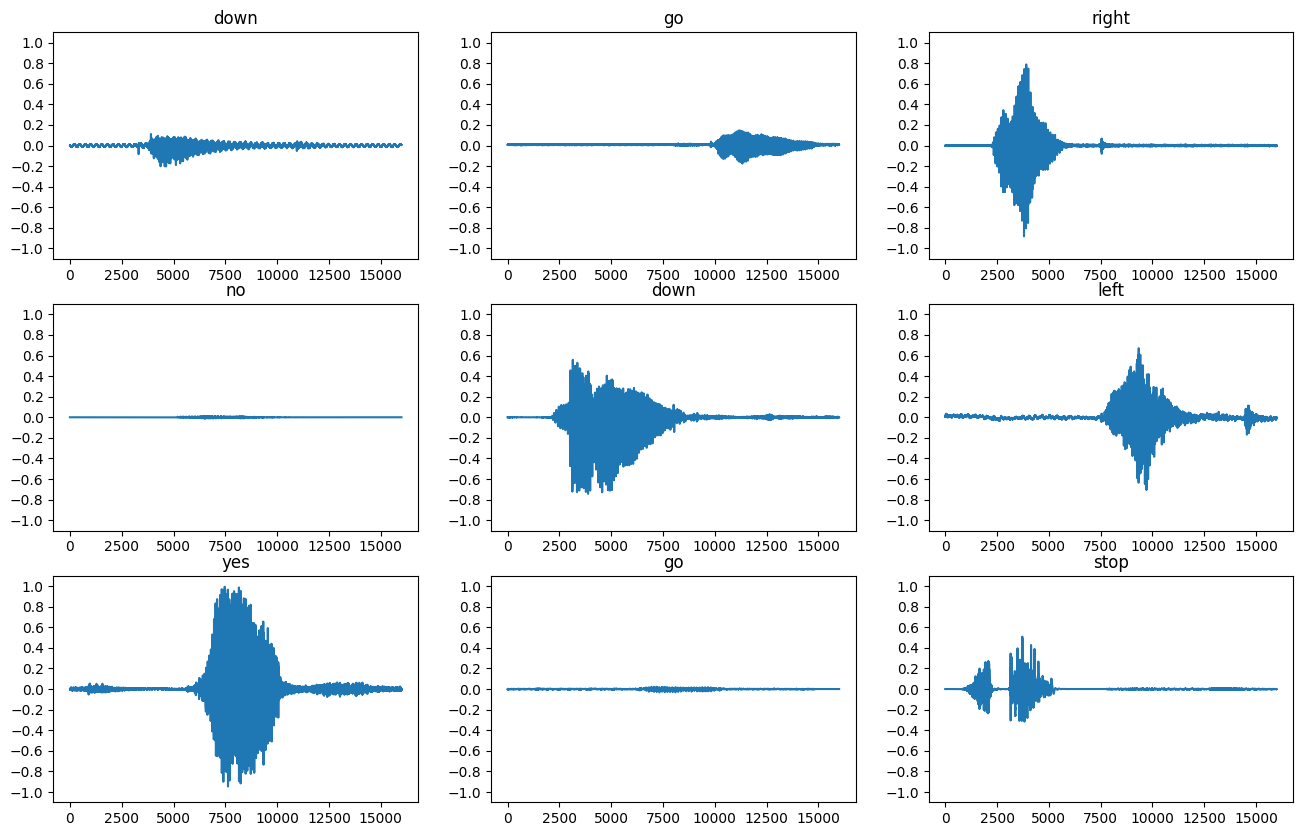

In [10]:
plt.figure(figsize=(16,10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows,cols,i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2,1.2,0.2))
  plt.ylim([-1.1,1.1])

In [11]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[...,tf.newaxis]
  return spectrogram

In [12]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label: ',label)
  print('Waveform shape: ',waveform.shape)
  print('Spectrogram shape: ',spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform,rate=16000))

Label:  down
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Label:  go
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Label:  right
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape)>2:
    assert len(spectrogram.shape)==3
    spectrogram=np.squeeze(spectrogram,axis=-1)

  log_spec=np.log(spectrogram.T+np.finfo(float).eps)
  height=log_spec.shape[0]
  width=log_spec.shape[1]
  X=np.linspace(0,np.size(spectrogram), num=width, dtype=int)
  Y=range(height)
  ax.pcolormesh(X,Y,log_spec)

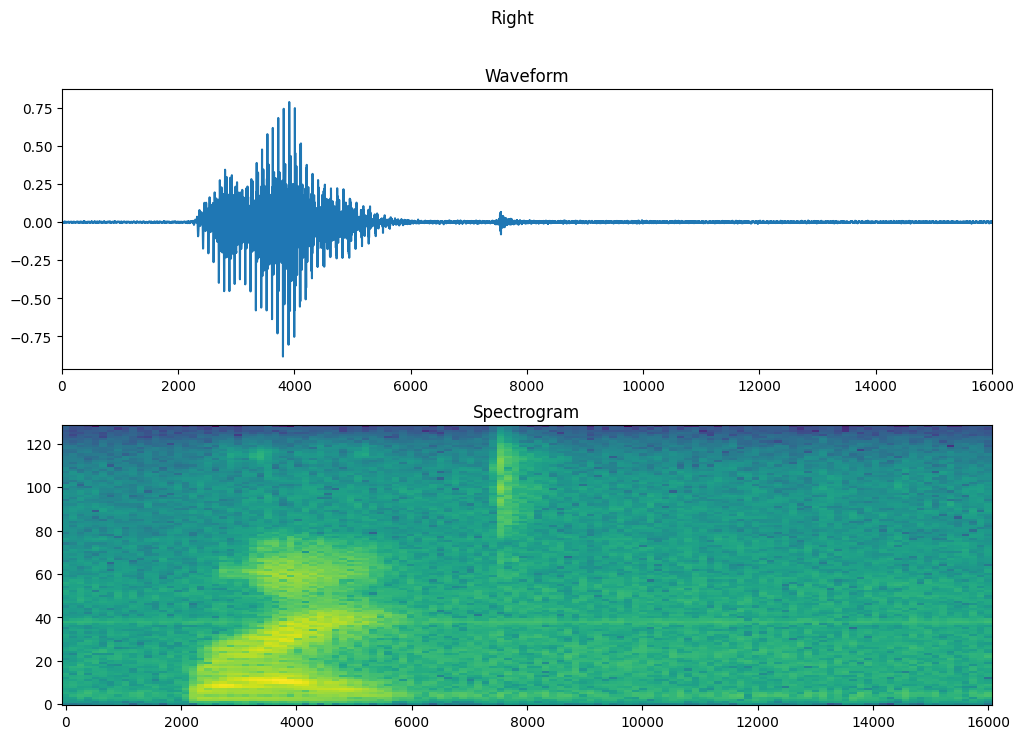

In [14]:
fig,axes=plt.subplots(2,figsize=(12,8))
timescale=np.arange(waveform.shape[0])
axes[0].plot(timescale,waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0,16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds=make_spec_ds(train_ds)
val_spectrogram_ds=make_spec_ds(val_ds)
test_spectrogram_ds=make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

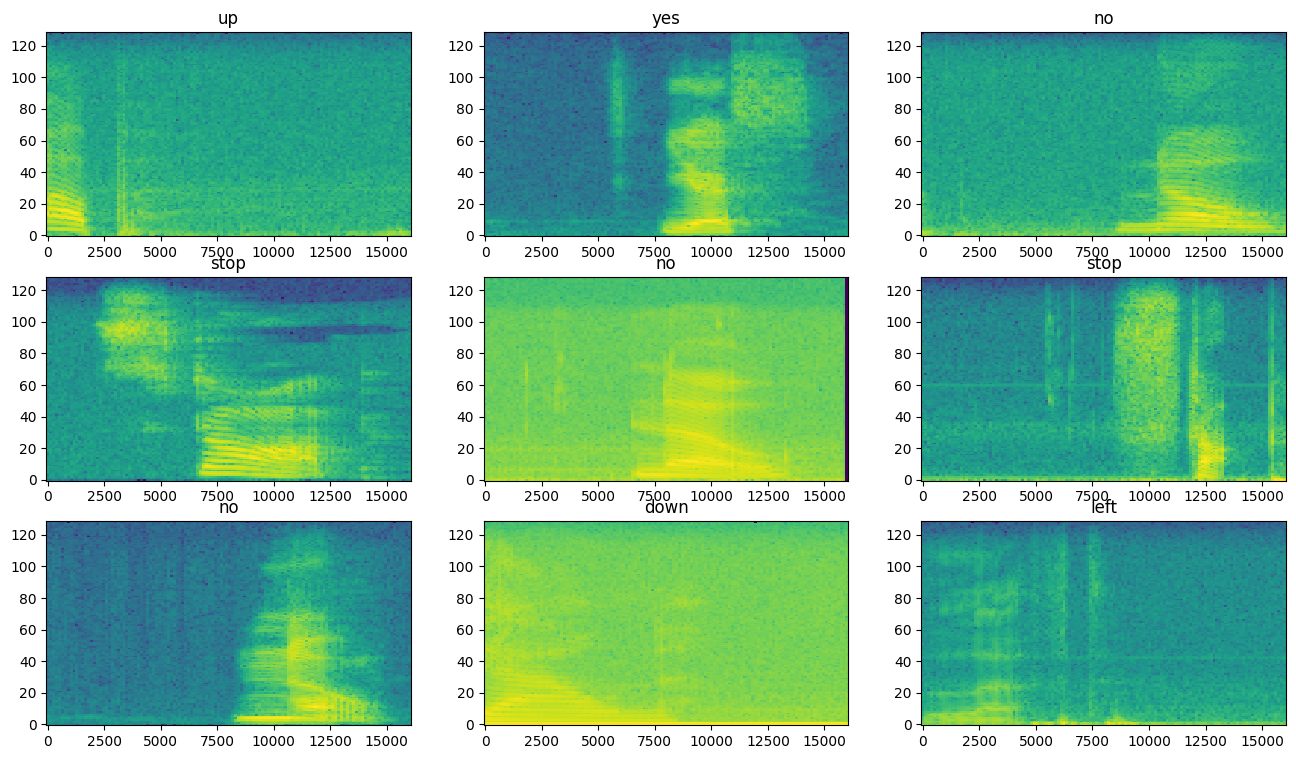

In [23]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [24]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [26]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:',input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(32,3, activation='relu'),
    layers.Conv2D(64,3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [29]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
100/100 [==============================] - 29s 275ms/step - loss: 1.7312 - accuracy: 0.3775 - val_loss: 1.3184 - val_accuracy: 0.5612
Epoch 2/10
100/100 [==============================] - 19s 194ms/step - loss: 1.1654 - accuracy: 0.5908 - val_loss: 0.9022 - val_accuracy: 0.7227
Epoch 3/10
100/100 [==============================] - 34s 341ms/step - loss: 0.8748 - accuracy: 0.6958 - val_loss: 0.7394 - val_accuracy: 0.7786
Epoch 4/10
100/100 [==============================] - 31s 306ms/step - loss: 0.7241 - accuracy: 0.7455 - val_loss: 0.6655 - val_accuracy: 0.7930
Epoch 5/10
100/100 [==============================] - 31s 310ms/step - loss: 0.6180 - accuracy: 0.7822 - val_loss: 0.6351 - val_accuracy: 0.8242
Epoch 6/10
100/100 [==============================] - 29s 284ms/step - loss: 0.5485 - accuracy: 0.8055 - val_loss: 0.5687 - val_accuracy: 0.8190
Epoch 7/10
100/100 [==============================] - 31s 314ms/step - loss: 0.4857 - accuracy: 0.8231 - val_loss: 0.5372 - val_ac

Text(0, 0.5, 'Accuracu [%]')

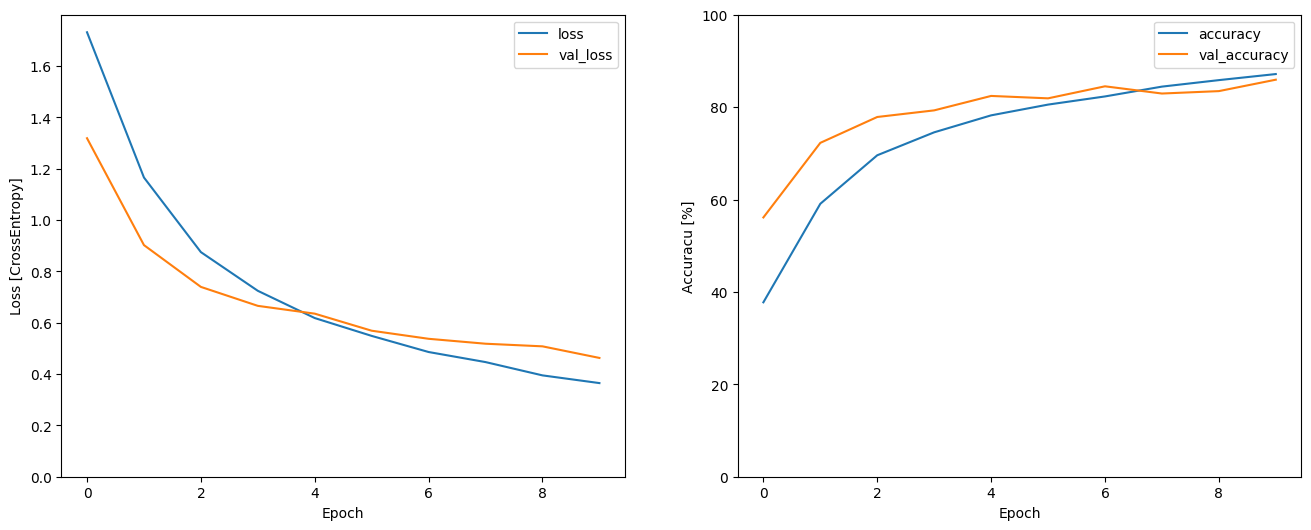

In [31]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Accuracu [%]')

In [32]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 3s 195ms/step - loss: 0.4638 - accuracy: 0.8486


{'loss': 0.46377232670783997, 'accuracy': 0.848557710647583}

In [33]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 69ms/step


In [34]:
y_pred = tf.argmax(y_pred, axis=1)

In [35]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab:lab)), axis=0)

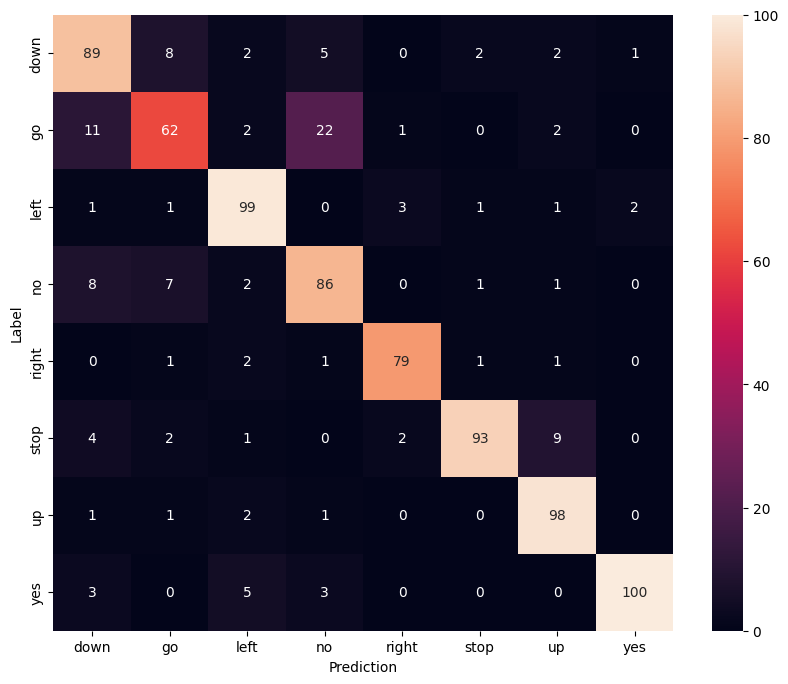

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

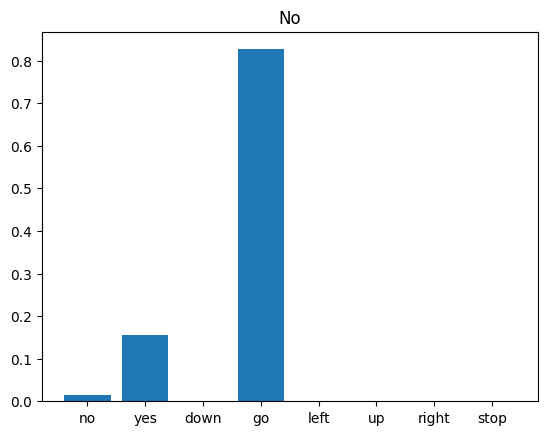

In [38]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [39]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    self.__call__.get_concrete_function(
      x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
      x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

  @tf.function
  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1,desired_samples=16000)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids':class_ids,
            'class_names':class_names}

In [40]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.05119543,  2.4543498 , -2.1803272 ,  4.1229973 , -3.6758647 ,
         -3.3860376 , -2.8209817 , -3.2035532 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [41]:
tf.saved_model.save(export,"saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis,:])

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.05119543,  2.4543498 , -2.1803272 ,  4.1229973 , -3.6758647 ,
         -3.3860376 , -2.8209817 , -3.2035532 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}